<a href="https://colab.research.google.com/github/siddu49/Minor_Project/blob/main/PCA_ViT_IndianPines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA + Vision Transformer (ViT) for Indian Pines Dataset
---
This notebook builds an **end-to-end PCA + Vision Transformer (ViT)** model for hyperspectral image classification on the Indian Pines dataset.

**Pipeline Overview:**
1. Load the `.mat` files for Indian Pines data and ground truth.
2. Apply PCA to reduce spectral dimensions.
3. Extract spatial patches centered on labeled pixels.
4. Build a small Vision Transformer (TinyViT) in PyTorch.
5. Perform a forward pass to verify model correctness.

---

In [16]:
import numpy as np
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from pathlib import Path

# -------- settings --------
PATCH_SIZE = 9
PCA_COMPONENTS = 3
OUTDIR = Path("./pca_vit_prepared")
OUTDIR.mkdir(exist_ok=True)

# -------- load data --------
cube = loadmat("Indian_pines_corrected (2).mat")["indian_pines_corrected"]
gt   = loadmat("Indian_pines_gt (2).mat")["indian_pines_gt"]
print("Cube:", cube.shape, "GT:", gt.shape)

H, W, C = cube.shape
n_classes = int(gt.max())
print("Classes:", n_classes)

# -------- PCA reduction --------
cube_2d = cube.reshape(-1, C)
pca = PCA(n_components=PCA_COMPONENTS, whiten=True, random_state=42)
cube_pca = pca.fit_transform(cube_2d)
cube_pca = cube_pca.reshape(H, W, PCA_COMPONENTS)
print("PCA done:", cube_pca.shape)

# -------- extract labeled patches --------
margin = PATCH_SIZE // 2
padded = np.pad(cube_pca, ((margin,margin),(margin,margin),(0,0)), mode="reflect")
patches, labels = [], []

for i in range(margin, H + margin):
    for j in range(margin, W + margin):
        label = gt[i - margin, j - margin]
        if label == 0:   # skip unlabeled
            continue
        patch = padded[i - margin:i + margin + 1,
                       j - margin:j + margin + 1, :]
        patches.append(patch)
        labels.append(label - 1)   # make labels 0-based

patches = np.stack(patches)
labels = np.array(labels)
print("Extracted patches:", patches.shape, "Labels:", labels.shape)

# -------- split train/test --------
train_idx, test_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.3,
    random_state=42,
    stratify=labels
)

# -------- save --------
np.save(OUTDIR / "patches.npy", patches)
np.save(OUTDIR / "labels.npy", labels)
np.save(OUTDIR / "train_idx.npy", train_idx)
np.save(OUTDIR / "test_idx.npy", test_idx)
print("Saved to", OUTDIR.resolve())


Cube: (145, 145, 200) GT: (145, 145)
Classes: 16
PCA done: (145, 145, 3)
Extracted patches: (10249, 9, 9, 3) Labels: (10249,)
Saved to /content/pca_vit_prepared


In [11]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [12]:
# Hyperparameters
HYPERPARAMS = {
    'pca_components': 3,
    'patch_size': 9,
    'patch_stride': 1,
    'train_ratio': 0.3,
    'random_seed': 42,
    'num_classes': 16,
    'vit_dim': 128,
    'vit_depth': 4,
    'vit_heads': 4,
    'mlp_hidden': 256,
}

DATA_FILES = {
    'hsi': '/content/Indian_pines_corrected (2).mat',
    'gt': '/content/Indian_pines_gt (2).mat'
}


In [13]:
def load_indian_pines(hsi_path, gt_path):
    mat_hsi = loadmat(hsi_path)
    mat_gt = loadmat(gt_path)
    possible_hsi_vars = [k for k in mat_hsi.keys() if not k.startswith('__')]
    possible_gt_vars = [k for k in mat_gt.keys() if not k.startswith('__')]
    print('HSI variables:', possible_hsi_vars)
    print('GT variables:', possible_gt_vars)
    hsi = mat_hsi[possible_hsi_vars[0]]
    gt = mat_gt[possible_gt_vars[0]]
    print('HSI shape:', hsi.shape, 'GT shape:', gt.shape)
    return hsi, gt

def apply_pca(hsi, n_components=3):
    H, W, B = hsi.shape
    flat = hsi.reshape(-1, B)
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(flat)
    out = reduced.reshape(H, W, n_components)
    print('Explained variance ratio sum:', pca.explained_variance_ratio_.sum())
    return out, pca

def extract_patches(img, gt, patch_size=9, stride=1):
    H, W, C = img.shape
    pad = patch_size // 2
    img_pad = np.pad(img, ((pad, pad), (pad, pad), (0,0)), mode='reflect')
    gt_pad = np.pad(gt, ((pad, pad), (pad, pad)), mode='constant', constant_values=0)
    patches, labels = [], []
    for i in range(pad, pad + H, stride):
        for j in range(pad, pad + W, stride):
            label = int(gt_pad[i, j])
            if label == 0:
                continue
            patch = img_pad[i-pad:i+pad+1, j-pad:j+pad+1, :]
            patches.append(patch)
            labels.append(label-1)
    patches = np.array(patches, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)
    print(f'Extracted {len(patches)} labelled patches')
    return patches, labels


In [14]:
def prepare_data():
    params = HYPERPARAMS
    hsi, gt = load_indian_pines(DATA_FILES['hsi'], DATA_FILES['gt'])
    pca_img, _ = apply_pca(hsi, params['pca_components'])
    patches, labels = extract_patches(pca_img, gt, params['patch_size'], params['patch_stride'])
    from sklearn.model_selection import train_test_split
    idx = np.arange(len(labels))
    train_idx, test_idx = train_test_split(idx, train_size=params['train_ratio'], random_state=params['random_seed'])
    return patches, labels, train_idx, test_idx

patches, labels, train_idx, test_idx = prepare_data()
print('Patches:', patches.shape, 'Labels:', labels.shape)


HSI variables: ['indian_pines_corrected']
GT variables: ['indian_pines_gt']
HSI shape: (145, 145, 200) GT shape: (145, 145)
Explained variance ratio sum: 0.9352152488891898
Extracted 10249 labelled patches
Patches: (10249, 9, 9, 3) Labels: (10249,)


In [15]:
class HSIPatchDataset(Dataset):
    def __init__(self, patches, labels, indices):
        self.patches = patches[indices]
        self.labels = labels[indices]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = np.transpose(self.patches[idx], (2,0,1)).copy()
        return torch.tensor(x), torch.tensor(self.labels[idx])

class SimplePatchEmbedding(nn.Module):
    def __init__(self, in_ch, patch_size, emb_dim):
        super().__init__()
        self.proj = nn.Linear(in_ch * patch_size * patch_size, emb_dim)
    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        return self.proj(x)

class TinyViT(nn.Module):
    def __init__(self, in_ch, patch_size, emb_dim, depth, heads, num_classes):
        super().__init__()
        self.embed = SimplePatchEmbedding(in_ch, patch_size, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, 256),
            nn.GELU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        b = x.shape[0]
        patch_emb = self.embed(x).unsqueeze(1)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        tokens = torch.cat([cls_tokens, patch_emb], dim=1)
        out = self.transformer(tokens)
        cls_out = out[:,0,:]
        return self.mlp_head(cls_out)

params = HYPERPARAMS
train_dataset = HSIPatchDataset(patches, labels, train_idx[:128])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

model = TinyViT(params['pca_components'], params['patch_size'], params['vit_dim'], params['vit_depth'], params['vit_heads'], params['num_classes'])
x, y = next(iter(train_loader))
print('Batch:', x.shape, y.shape)
logits = model(x.float())
print('Forward pass logits shape:', logits.shape)


Batch: torch.Size([8, 3, 9, 9]) torch.Size([8])
Forward pass logits shape: torch.Size([8, 16])


In [23]:
# train_pca_vit_indianpines.py
# Train TinyViT on PCA-reduced Indian Pines patches
import os, time, math
import numpy as np
from pathlib import Path
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
except Exception as e:
    raise RuntimeError("PyTorch not found. Install PyTorch to run this script.") from e

# ----------------- HYPERPARAMS -----------------
params = {
    'batch_size': 64,
    'epochs': 40,
    'lr': 1e-3,
    'pca_components': 3,
    'patch_size': 9,
    'num_classes': 16,
    'vit_dim': 128,
    'vit_depth': 4,
    'vit_heads': 4,
    'mlp_hidden': 256,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'max_train_samples': None  # add this line (or set to e.g. 2000 for quick testing)
}


OUTDIR = Path('./pca_vit_prepared')
OUTDIR.mkdir(parents=True, exist_ok=True)


In [25]:

# ----------------- LOAD DATA -----------------
required = ['patches.npy','labels.npy','train_idx.npy','test_idx.npy']
for f in required:
    if not (OUTDIR / f).exists():
        raise FileNotFoundError(f"Missing {f} in {OUTDIR}. Run the preprocessing script first.")

patches = np.load(OUTDIR / 'patches.npy')   # shape: [N, S, S, C]
labels = np.load(OUTDIR / 'labels.npy')     # shape: [N]
train_idx = np.load(OUTDIR / 'train_idx.npy')
test_idx = np.load(OUTDIR / 'test_idx.npy')

# optionally subsample training for quick runs
if params['max_train_samples'] is not None and len(train_idx) > params['max_train_samples']:
    rng = np.random.RandomState(42)
    train_idx = rng.choice(train_idx, size=params['max_train_samples'], replace=False)

class HSIDataset(Dataset):
    def __init__(self, patches, labels, indices):
        self.x = patches[indices].astype('float32')
        self.y = labels[indices].astype('int64')
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        img = self.x[idx]         # S x S x C
        img = np.transpose(img, (2,0,1)).copy()  # C x S x S
        return torch.from_numpy(img), int(self.y[idx])

train_ds = HSIDataset(patches, labels, train_idx)
test_ds = HSIDataset(patches, labels, test_idx)
train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=params['batch_size'], shuffle=False, num_workers=2, pin_memory=True)


In [26]:

# ----------------- MODEL -----------------
class SimplePatchEmbedding(nn.Module):
    def __init__(self, in_ch, patch_size, emb_dim):
        super().__init__()
        self.proj = nn.Linear(in_ch * patch_size * patch_size, emb_dim)
    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        return self.proj(x)

class TinyViT(nn.Module):
    def __init__(self, in_ch, patch_size, emb_dim, depth, heads, num_classes):
        super().__init__()
        self.embed = SimplePatchEmbedding(in_ch, patch_size, emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=heads, dim_feedforward=emb_dim*2, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_dim))
        self.mlp = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, params['mlp_hidden']),
            nn.GELU(),
            nn.Linear(params['mlp_hidden'], num_classes)
        )
    def forward(self, x):
        # x: B x C x S x S
        b = x.shape[0]
        patch_emb = self.embed(x).unsqueeze(1)   # B x 1 x emb
        cls_tokens = self.cls_token.expand(b, -1, -1)
        tokens = torch.cat([cls_tokens, patch_emb], dim=1)  # B x 2 x emb
        out = self.transformer(tokens)                       # B x 2 x emb
        cls_out = out[:,0,:]
        logits = self.mlp(cls_out)
        return logits

device = torch.device(params['device'])
model = TinyViT(in_ch=params['pca_components'],
                patch_size=params['patch_size'],
                emb_dim=params['vit_dim'],
                depth=params['vit_depth'],
                heads=params['vit_heads'],
                num_classes=params['num_classes']).to(device)

opt = torch.optim.Adam(model.parameters(), lr=params['lr'])
criterion = nn.CrossEntropyLoss()

In [27]:
# ----------------- EVAL -----------------
def evaluate(model, loader):
    model.eval()
    preds = []
    trues = []
    loss_sum = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_sum += float(loss) * xb.size(0)
            preds.append(logits.argmax(dim=1).cpu().numpy())
            trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    oa = (preds == trues).sum() / len(trues)
    cm = confusion_matrix(trues, preds, labels=list(range(params['num_classes'])))
    per_class_acc = np.array([ cm[i,i] / (cm[i].sum()+1e-12) if cm[i].sum() > 0 else 0.0 for i in range(params['num_classes']) ])
    aa = per_class_acc.mean()
    try:
        kappa = cohen_kappa_score(trues, preds)
    except:
        kappa = float('nan')
    return {'loss': loss_sum/len(trues), 'oa': oa, 'aa': aa, 'kappa': kappa, 'cm': cm, 'per_class_acc': per_class_acc}

In [28]:

# ----------------- TRAIN LOOP -----------------
history = {'train_loss': [], 'val_loss': [], 'val_oa': [], 'val_aa': [], 'val_kappa': []}
best_oa = 0.0
for epoch in range(1, params['epochs']+1):
    model.train()
    running_loss = 0.0
    t0 = time.time()
    for xb, yb in train_loader:
        xb = xb.to(device).float()
        yb = yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()
        running_loss += float(loss) * xb.size(0)
    train_loss = running_loss / len(train_ds)
    val = evaluate(model, test_loader)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val['loss'])
    history['val_oa'].append(val['oa'])
    history['val_aa'].append(val['aa'])
    history['val_kappa'].append(val['kappa'])
    elapsed = time.time() - t0
    print(f"Epoch {epoch}/{params['epochs']} — train_loss={train_loss:.4f} val_loss={val['loss']:.4f} OA={val['oa']:.4f} AA={val['aa']:.4f} Kappa={val['kappa']:.4f} time={elapsed:.1f}s")
    # checkpoint best OA
    if val['oa'] > best_oa:
        best_oa = val['oa']
        ckpt = {
            'model_state': model.state_dict(),
            'opt_state': opt.state_dict(),
            'epoch': epoch,
            'oa': val['oa']
        }
        torch.save(ckpt, OUTDIR / 'checkpoint.pth')


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-2665672371.py:16: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  running_loss += float(loss) * xb.size(0)


Epoch 1/40 — train_loss=1.1965 val_loss=0.8577 OA=0.6667 AA=0.5313 Kappa=0.6150 time=6.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/40 — train_loss=0.7799 val_loss=0.6439 OA=0.7532 AA=0.6636 Kappa=0.7184 time=4.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/40 — train_loss=0.5525 val_loss=0.4729 OA=0.8192 AA=0.8122 Kappa=0.7932 time=6.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/40 — train_loss=0.4290 val_loss=0.3986 OA=0.8524 AA=0.7752 Kappa=0.8313 time=4.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/40 — train_loss=0.3668 val_loss=0.3556 OA=0.8624 AA=0.8689 Kappa=0.8437 time=4.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 6/40 — train_loss=0.3743 val_loss=0.2774 OA=0.8995 AA=0.9000 Kappa=0.8853 time=5.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7/40 — train_loss=0.2394 val_loss=0.2438 OA=0.9132 AA=0.9198 Kappa=0.9011 time=4.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 8/40 — train_loss=0.2500 val_loss=0.1772 OA=0.9285 AA=0.9104 Kappa=0.9187 time=5.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 9/40 — train_loss=0.1936 val_loss=0.2001 OA=0.9356 AA=0.9267 Kappa=0.9264 time=4.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/40 — train_loss=0.2275 val_loss=0.2560 OA=0.9080 AA=0.9024 Kappa=0.8953 time=5.7s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11/40 — train_loss=0.2012 val_loss=0.2179 OA=0.9200 AA=0.9065 Kappa=0.9089 time=5.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12/40 — train_loss=0.1796 val_loss=0.1436 OA=0.9522 AA=0.9366 Kappa=0.9455 time=5.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13/40 — train_loss=0.1821 val_loss=0.2293 OA=0.9249 AA=0.8827 Kappa=0.9143 time=6.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14/40 — train_loss=0.1809 val_loss=0.1977 OA=0.9288 AA=0.9330 Kappa=0.9186 time=5.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15/40 — train_loss=0.2227 val_loss=0.1226 OA=0.9532 AA=0.9495 Kappa=0.9466 time=6.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 16/40 — train_loss=0.1919 val_loss=0.1714 OA=0.9382 AA=0.9291 Kappa=0.9298 time=5.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 17/40 — train_loss=0.1419 val_loss=0.1359 OA=0.9574 AA=0.9623 Kappa=0.9513 time=5.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 18/40 — train_loss=0.1380 val_loss=0.1682 OA=0.9421 AA=0.9209 Kappa=0.9339 time=5.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19/40 — train_loss=0.1493 val_loss=0.1841 OA=0.9408 AA=0.8813 Kappa=0.9326 time=5.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 20/40 — train_loss=0.1198 val_loss=0.1694 OA=0.9428 AA=0.9554 Kappa=0.9348 time=6.0s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 21/40 — train_loss=0.1279 val_loss=0.1579 OA=0.9522 AA=0.9357 Kappa=0.9455 time=5.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 22/40 — train_loss=0.1292 val_loss=0.1219 OA=0.9577 AA=0.9524 Kappa=0.9517 time=6.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 23/40 — train_loss=0.1257 val_loss=0.1471 OA=0.9528 AA=0.9430 Kappa=0.9462 time=5.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 24/40 — train_loss=0.1345 val_loss=0.1516 OA=0.9499 AA=0.9667 Kappa=0.9429 time=6.1s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 25/40 — train_loss=0.1387 val_loss=0.1405 OA=0.9532 AA=0.9557 Kappa=0.9467 time=5.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 26/40 — train_loss=0.1210 val_loss=0.1415 OA=0.9512 AA=0.9274 Kappa=0.9444 time=5.9s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 27/40 — train_loss=0.1006 val_loss=0.1487 OA=0.9512 AA=0.9573 Kappa=0.9444 time=5.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 28/40 — train_loss=0.0717 val_loss=0.1866 OA=0.9476 AA=0.9515 Kappa=0.9403 time=6.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 29/40 — train_loss=0.2270 val_loss=0.1402 OA=0.9541 AA=0.9452 Kappa=0.9477 time=6.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 30/40 — train_loss=0.1740 val_loss=0.1482 OA=0.9493 AA=0.9290 Kappa=0.9421 time=5.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 31/40 — train_loss=0.1248 val_loss=0.0780 OA=0.9698 AA=0.9711 Kappa=0.9654 time=6.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 32/40 — train_loss=0.1185 val_loss=0.1388 OA=0.9567 AA=0.9623 Kappa=0.9507 time=5.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 33/40 — train_loss=0.1292 val_loss=0.1049 OA=0.9633 AA=0.9447 Kappa=0.9581 time=6.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 34/40 — train_loss=0.0978 val_loss=0.1170 OA=0.9629 AA=0.9711 Kappa=0.9577 time=5.4s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 35/40 — train_loss=0.1224 val_loss=0.1544 OA=0.9519 AA=0.9499 Kappa=0.9451 time=6.3s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 36/40 — train_loss=0.1356 val_loss=0.1295 OA=0.9509 AA=0.9660 Kappa=0.9441 time=5.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 37/40 — train_loss=0.0855 val_loss=0.0995 OA=0.9750 AA=0.9605 Kappa=0.9714 time=6.2s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 38/40 — train_loss=0.0859 val_loss=0.0779 OA=0.9766 AA=0.9713 Kappa=0.9733 time=5.5s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 39/40 — train_loss=0.0835 val_loss=0.1411 OA=0.9541 AA=0.9536 Kappa=0.9477 time=5.8s


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 40/40 — train_loss=0.1153 val_loss=0.1417 OA=0.9551 AA=0.9392 Kappa=0.9487 time=6.3s


Training finished. Best validation OA: 0.9765853658536585
Saved artifacts in pca_vit_prepared


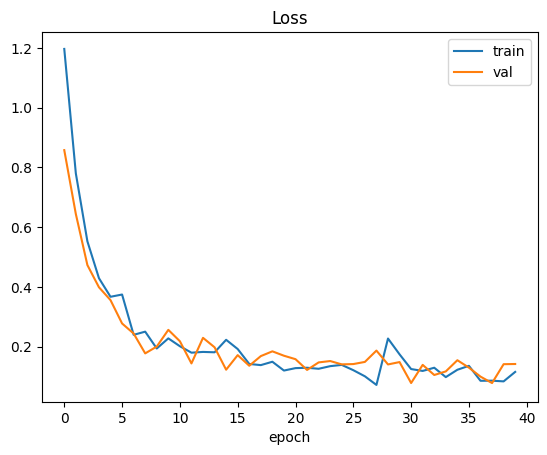

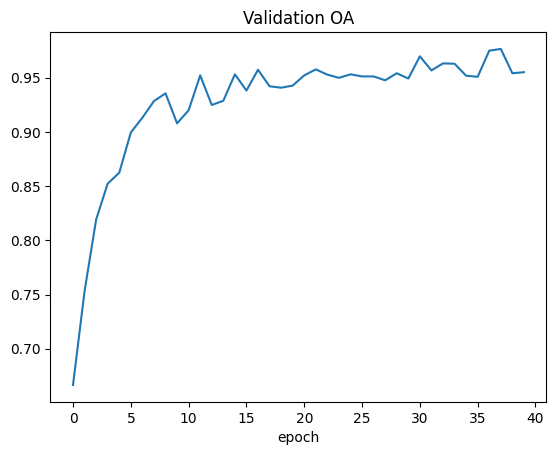

In [29]:
# ----------------- SAVE & PLOTS -----------------
np.save(OUTDIR / 'train_history.npy', history)
torch.save(model.state_dict(), OUTDIR / 'final_model.pth')
print("Training finished. Best validation OA:", best_oa)
# Loss plot
plt.figure()
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.savefig(OUTDIR / 'loss_plot.png')
# OA plot
plt.figure()
plt.plot(history['val_oa'])
plt.title('Validation OA')
plt.xlabel('epoch')
plt.savefig(OUTDIR / 'oa_plot.png')
print("Saved artifacts in", OUTDIR)
